# DigiProf

DigiProf is a web application that utilizes machine learning to recognize numbers written by children, and vocalizing these numbers into sound using text-to-speech technology. The app is made to help children actively learn and recall numbers by vocalizing what they have written, thus instilling the concept of Autodidacticism or self-learning. We hope to instill a love for learning and curiosity for exploration in children that will guarantee quality education with long term self-teaching habits.

This project is developed by:

- A. P. Dumosmog
- K. M. Quirapas
- D. C. Roxas

This project is inspired by:
Sustainable Development Goals 4 — Quality Education

## 1. Importing the dataset and libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio
from scipy import optimize
from IPython.display import display, clear_output
from PIL import Image

import os
import glob 
from skimage import io
import skimage
import random

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

## 2. Data Preprocessing

.\data\8\image(137).jpg


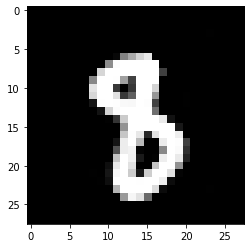

In [2]:
datasetpath = []
generalpath = r".\data"
classnames = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Getting the images from the ./data folder
for index in range(10):
    indivpath = os.path.join(generalpath, classnames[index], "*")
    indivpath = glob.glob(indivpath)
    datasetpath.append(indivpath)

datasetpath = np.ravel(datasetpath)
#print(datasetpath)
#Transforming the images to matrices
dataset = []
for i in range(datasetpath.shape[0]):
    image = io.imread(datasetpath[i])
    
    #Convert to grayscale
    grayimage = skimage.color.rgb2gray(image)
    
    #Inverting the grayscale image
    for i in range(grayimage.shape[0]):
        for j in range(grayimage.shape[1]):
            grayimage[i][j] = 1 - grayimage[i][j]
            
    dataset.append(grayimage)

#Normalization
normdataset = []
for image in dataset:
    normimage = (image - np.min(image)) / (np.max(image) - np.min(image))
    normdataset.append(normimage)

#Print a random image from the dataset
rng = random.randint(0, len(normdataset)-1)
sample = normdataset[rng].reshape((28,28))
print(datasetpath[rng])
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
ax.imshow(sample, cmap = 'gray')

In [3]:
#Creating the X feature and Y target matrices
X = []

for image in normdataset:
    X.append(np.ravel(image))
    
Y = np.genfromtxt("./data/labels.csv", dtype=np.int32, delimiter=",")

X = np.array(X)
Y = np.array(Y)
Yreshaped = Y.reshape(-1, 1)

## 3. Exploratory Data Analysis

### 3.1 Dataset basic information

In [4]:
df = pd.DataFrame(X)
print("Sample pixels from the dataset\n")
print(df.head())

Sample pixels from the dataset

   0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   778  779  780  781  782  783  
0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 784 columns]


In [5]:
print("Features matrix X basic information\n")
print(df.info())
print("X shape: "+str(X.shape))


Features matrix X basic information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 784 entries, 0 to 783
dtypes: float64(784)
memory usage: 1.2 MB
None
X shape: (200, 784)


In [6]:
df2 = pd.DataFrame(Y)
print("Target vector Y basic information\n")
print(df2.info())
print("Y shape: "+str(Y.shape))

Target vector Y basic information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       200 non-null    int32
dtypes: int32(1)
memory usage: 928.0 bytes
None
Y shape: (200,)


### 3.2 Distribution of Labels

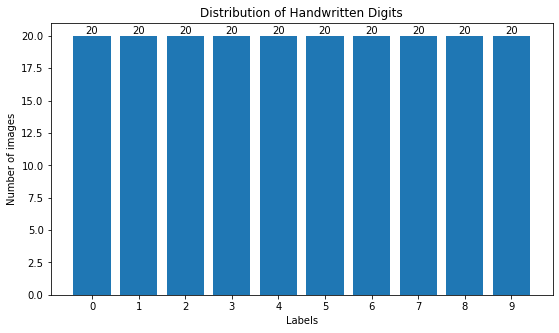

In [7]:
distrib = {}
for i in Y:
    if i not in distrib:
        distrib[i] = 1
    else:
        distrib[i] += 1
#plt.bar(distrib.keys(), distrib.values(), x="Labels", y="Number of images")

fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(distrib.keys(), distrib.values())
ax.set_xticks(range(10))
ax.set_xlabel('Labels')
ax.set_ylabel('Number of images')
ax.set_title("Distribution of Handwritten Digits")
ax.bar_label(bars)

plt.show()

### 3.3 Pixel Intensity

In [8]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,200.0,200.0,200.0,200.000000,200.000000,200.0,200.0,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.0,200.0
mean,0.0,0.0,0.0,0.000059,0.000059,0.0,0.0,0.000020,0.000235,0.000118,...,0.036235,0.041902,0.040039,0.034314,0.020333,0.01002,0.010000,0.000098,0.0,0.0
std,0.0,0.0,0.0,0.000478,0.000478,0.0,0.0,0.000277,0.002280,0.000671,...,0.184806,0.195735,0.196343,0.175253,0.136902,0.09955,0.099748,0.001386,0.0,0.0
min,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
25%,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
50%,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
75%,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
max,0.0,0.0,0.0,0.003922,0.003922,0.0,0.0,0.003922,0.031373,0.003922,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.019608,0.0,0.0


## 4. Data Modeling

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(192, activation='sigmoid'),
    keras.layers.Dense(10)
])
mnist = keras.datasets.mnist
print(model.summary())
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0

loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optim = keras.optimizers.Adam(lr = .001)
metrics = ["accuracy"]

model.compile(loss=loss,optimizer=optim, metrics=metrics)

batch_size = 20
epochs = 18
model.fit(x_train,y_train, batch_size = batch_size, epochs=epochs, shuffle = True, verbose = 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 192)               150720    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1930      
Total params: 152,650
Trainable params: 152,650
Non-trainable params: 0
_________________________________________________________________
None


D:\anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/18
3000/3000 [==============================] - 13s 4ms/step - loss: 0.3363 - accuracy: 0.9086
Epoch 2/18
3000/3000 [==============================] - 26s 9ms/step - loss: 0.1628 - accuracy: 0.9526
Epoch 3/18
3000/3000 [==============================] - 24s 8ms/step - loss: 0.1117 - accuracy: 0.9673
Epoch 4/18
3000/3000 [==============================] - 15s 5ms/step - loss: 0.0815 - accuracy: 0.9758
Epoch 5/18
3000/3000 [==============================] - 14s 5ms/step - loss: 0.0626 - accuracy: 0.9817 0s - loss: 0.0626 - accuracy: 
Epoch 6/18
3000/3000 [==============================] - 14s 5ms/step - loss: 0.0494 - accuracy: 0.9856
Epoch 7/18
3000/3000 [==============================] - 13s 4ms/step - loss: 0.0381 - accuracy: 0.9892
Epoch 8/18
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0301 - accuracy: 0.9921
Epoch 9/18
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0239 - accuracy: 0.9938 1s - loss: 0.023 - ETA: 0s - loss: 0.0239 

## 5. Data Testing

In [10]:
model.evaluate(X,Y, batch_size = 20, verbose = 1)

10/10 [==============================] - 2s 26ms/step - loss: 1.5360 - accuracy: 0.7550


[1.5359545946121216, 0.7549999952316284]